In [1]:
from warnings import simplefilter

import numpy as np
import pandas as pd
from scipy.stats import linregress, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm.notebook import tqdm

import plot
from select_complex import Constraints, get_top_structure


simplefilter(action='ignore', category=FutureWarning)
tqdm.pandas()


# Set input files and directories
DGE_FILE = '../data/dge/dge.txt'
SITES_FILE = '../results/site_predictions/sites.txt'
STRUCT_DIR = '../results/RNAsubopt/'

# Set directory for saving plots
FIG_DIR = '../results/graphs/FIG3/'

# Set color palettes
VOLCANO_PALETTE = ['#000092', '#e60000', '#a23582']
DIST_PALETTE = ['#000000', '#023eff', '#00d7ff', '#f14cc1', '#e8000b']

## FIG. 3A

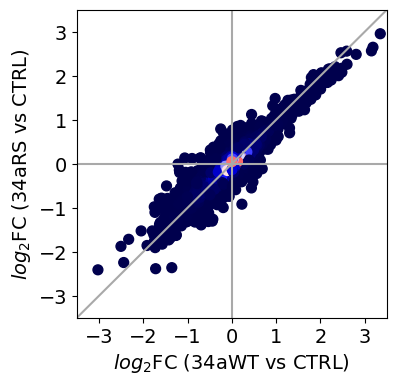

Genes: 13740 / R2: 0.85 / Slope: 0.86



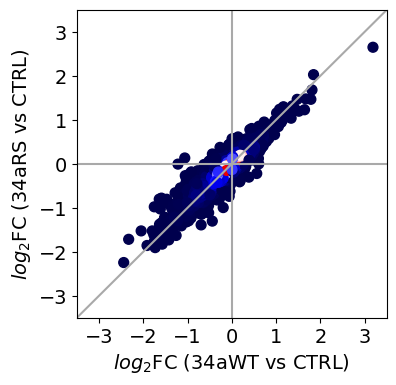

Genes: 5127 / R2: 0.86 / Slope: 0.86



<Figure size 400x400 with 0 Axes>

In [2]:
x_var = 'log2fc WT-NC'
y_var = 'log2fc RS-NC'

# Read data: all genes
data = pd.read_csv(DGE_FILE, sep='\t')

plot.scatter(
    data, x=x_var, y=y_var, kde=True, xlim=(-3.5, 3.5), ylim=(-3.5, 3.5),
    xticks=(-3, 3, 1), yticks=(-3, 3, 1),
    diagonal=True, hlines=[0], vlines=[0],
    xlabel='$log_{2}$FC (34aWT vs CTRL)', ylabel='$log_{2}$FC (34aRS vs CTRL)',
    outfile=FIG_DIR+'3A_all')
model = linregress(data[x_var], data[y_var])
print(*['Genes: '+str(data.shape[0]),
        'R2: '+plot.round_value(model.rvalue**2, 2),
        'Slope: '+plot.round_value(model.slope, 2)+'\n'], sep=' / ')


# Read data: genes with >=1 site
data = pd.read_csv(DGE_FILE, sep='\t')
sites = pd.read_csv(SITES_FILE, sep='\t')
sites.drop_duplicates(subset='Gene ID', inplace=True)
data = pd.merge(data, sites['Gene ID'])

plot.scatter(
    data, x=x_var, y=y_var, kde=True, xlim=(-3.5, 3.5), ylim=(-3.5, 3.5),
    xticks=(-3, 3, 1), yticks=(-3, 3, 1),
    diagonal=True, hlines=[0], vlines=[0],
    xlabel='$log_{2}$FC (34aWT vs CTRL)', ylabel='$log_{2}$FC (34aRS vs CTRL)',
    outfile=FIG_DIR+'3A_sites')
model = linregress(data[x_var], data[y_var])
print(*['Genes: '+str(data.shape[0]),
        'R2: '+plot.round_value(model.rvalue**2, 2),
        'Slope: '+plot.round_value(model.slope, 2)+'\n'], sep=' / ')

## FIG. 3C

  0%|          | 0/3287 [00:00<?, ?it/s]

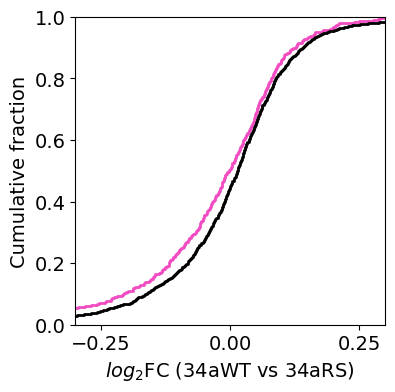

p = 5.8e-05 

      3P  count
0  False   2738
1   True    549 



  0%|          | 0/3287 [00:00<?, ?it/s]

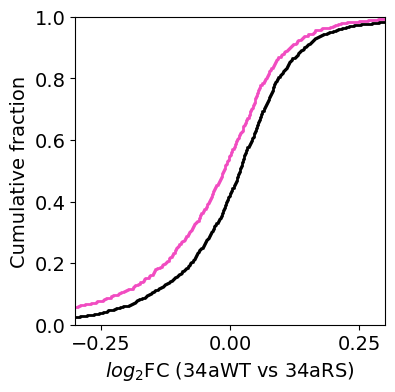

p = 5.3e-13 

      3P  count
0  False   2470
1   True    817 



<Figure size 400x400 with 0 Axes>

In [3]:
# Read data: genes with =1 site
data = pd.read_csv(DGE_FILE, sep='\t')
sites = pd.read_csv(SITES_FILE, sep='\t')
data = pd.merge(data, sites)
data.drop_duplicates(subset='Gene ID', keep=False, inplace=True)

x_var = 'log2fc WT-RS'
hue = '3P'
groups = [False, True]

for base in (13, 14):
    constraints = Constraints(
        force_paired=({base},),
        no_gu=True, offset=(-4, 4), max_mm_count=0, min_pairs=3)
    data['3P'] = data.progress_apply(
        get_top_structure, args=(STRUCT_DIR, constraints, True,), axis=1)

    plot.cumulative_hist(
        data, x=x_var, hue=hue, hue_order=groups,
        palette=DIST_PALETTE[:1]+DIST_PALETTE[3:4],
        xlim=(-0.3, 0.3), xticks=(-0.25, 0.25, 0.25),
        xlabel='$log_{2}$FC (34aWT vs 34aRS)',
        outfile=FIG_DIR+'3C_g'+str(base)+'.png')

    model = f_oneway(*[data[data[hue] == group][x_var] for group in groups])
    print('p =', plot.round_value(model.pvalue, 2), '\n')

    counts = data[hue].value_counts().reset_index()
    counts.sort_values(hue, key=np.vectorize(groups.index), inplace=True)
    print(counts, '\n')

## FIG. 3D

  0%|          | 0/3287 [00:00<?, ?it/s]

  0%|          | 0/3287 [00:00<?, ?it/s]

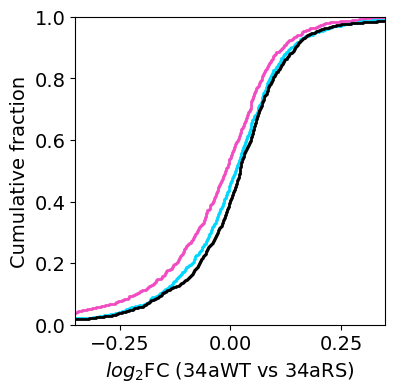

p = 1.3e-11 

   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
      No 3P Not g13-g14   -0.011 0.1441 -0.0246  0.0027  False
      No 3P     g13-g14  -0.0436    0.0 -0.0582  -0.029   True
Not g13-g14     g13-g14  -0.0327    0.0 -0.0479 -0.0174   True


            3P  count
2        No 3P   1339
0  Not g13-g14   1086
1      g13-g14    862 



<Figure size 400x400 with 0 Axes>

In [4]:
# Read data: genes with =1 site
data = pd.read_csv(DGE_FILE, sep='\t')
sites = pd.read_csv(SITES_FILE, sep='\t')
data = pd.merge(data, sites)
data.drop_duplicates(subset='Gene ID', keep=False, inplace=True)

# Predict structures: enforced pairing to g13 and/or g14
constraints = Constraints(
    force_paired=({13}, {14},),
    no_gu=True, offset=(-4, 4), max_mm_count=0, min_pairs=3)
data['3P g13/g14'] = data.progress_apply(
    get_top_structure, args=(STRUCT_DIR, constraints, True), axis=1)

# Predict structures: pairing anywhere
constraints = Constraints(
    no_gu=True, offset=(-4, 4), max_mm_count=0, min_pairs=3)
data['3P any'] = data.progress_apply(
    get_top_structure, args=(STRUCT_DIR, constraints, True), axis=1)

data['3P'] = data.apply(
    lambda x: 'g13-g14' if x['3P g13/g14'] == True
    else 'Not g13-g14' if x['3P any'] == True else 'No 3P', axis=1)

# Draw cumulative histogram plot
x_var = 'log2fc WT-RS'
hue = '3P'
groups = ['No 3P', 'Not g13-g14', 'g13-g14']
palette = DIST_PALETTE[:1]+DIST_PALETTE[2:4]

plot.cumulative_hist(
    data, x=x_var, hue=hue, hue_order=groups, palette=palette,
    xlim=(-0.35, 0.35), xticks=(-0.25, 0.25, 0.25),
    xlabel='$log_{2}$FC (34aWT vs 34aRS)',
    outfile=FIG_DIR+'3D')

model = f_oneway(*[data[data[hue] == group][x_var] for group in groups])
print('p =', plot.round_value(model.pvalue, 2), '\n')

hsd = pairwise_tukeyhsd(endog=data[x_var], groups=data[hue], alpha=0.05)
print(*str(hsd.summary()).split('\n')[2:-1], sep='\n')
print('\n')

counts = data[hue].value_counts(sort=False, dropna=False).reset_index()
counts.sort_values(hue, key=np.vectorize(groups.index), inplace=True)
print(counts, '\n')

## FIG. 3E

  0%|          | 0/8011 [00:00<?, ?it/s]

  0%|          | 0/8011 [00:00<?, ?it/s]

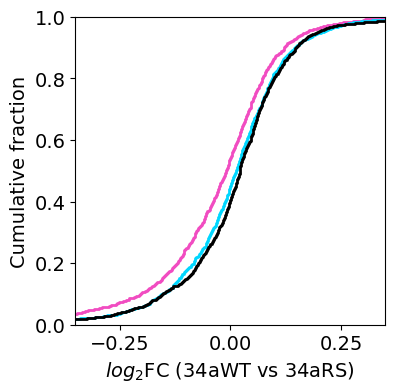

p = 4.3e-18 

group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0336    0.0  0.0223  0.045   True
     1      3   0.0405    0.0  0.0289  0.052   True
     2      3   0.0068 0.3731 -0.0051 0.0188  False


   3P  count
2   3   1544
1   2   1661
0   1   1922 



<Figure size 400x400 with 0 Axes>

In [5]:
# Read data: genes with >=1 site
data = pd.read_csv(DGE_FILE, sep='\t')
sites = pd.read_csv(SITES_FILE, sep='\t')
data = pd.merge(data, sites)

# Predict structures: enforced pairing to g13 and/or g14
constraints = Constraints(
    force_paired=({13}, {14},),
    no_gu=True, offset=(-4, 4), max_mm_count=0, min_pairs=3)
data['3P g13/g14'] = data.progress_apply(
    get_top_structure, args=(STRUCT_DIR, constraints, True), axis=1)

# Predict structures: pairing anywhere
constraints = Constraints(
    no_gu=True, offset=(-4, 4), max_mm_count=0, min_pairs=3)
data['3P any'] = data.progress_apply(
    get_top_structure, args=(STRUCT_DIR, constraints, True), axis=1)

# Rank the predictions
data['3P'] = data.apply(
    lambda x: 1 if x['3P g13/g14'] == True
    else 2 if x['3P any'] == True else 3, axis=1)

# Sort by prediction rank and keep first instance of each Gene ID
data.sort_values(by='3P', ascending=True, inplace=True)
data.drop_duplicates(subset='Gene ID', keep='first', inplace=True)

# Draw cumulative histogram plot
x_var = 'log2fc WT-RS'
hue = '3P'
groups = [3, 2, 1]
palette = DIST_PALETTE[:1]+DIST_PALETTE[2:4]

plot.cumulative_hist(
    data, x=x_var, hue=hue, hue_order=groups, palette=palette,
    xlim=(-0.35, 0.35), xticks=(-0.25, 0.25, 0.25),
    xlabel='$log_{2}$FC (34aWT vs 34aRS)',
    outfile=FIG_DIR+'3E')

model = f_oneway(*[data[data[hue] == group][x_var] for group in groups])
print('p =', plot.round_value(model.pvalue, 2), '\n')

hsd = pairwise_tukeyhsd(endog=data[x_var], groups=data[hue], alpha=0.05)
print(*str(hsd.summary()).split('\n')[2:-1], sep='\n')
print('\n')

counts = data[hue].value_counts(sort=False, dropna=False).reset_index()
counts.sort_values(hue, key=np.vectorize(groups.index), inplace=True)
print(counts, '\n')